### Imports

In [1]:
from sklearn.model_selection import train_test_split
from random import shuffle
import skimage.transform as transform
import csv
import cv2
import numpy as np
import sklearn
import math

# Keras
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda,  Dropout,Cropping2D, Convolution2D
from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load data


In [2]:
samples = []
with open("./data/driving_log.csv") as csvFile:
    csvReder = csv.reader(csvFile)
    for line in  csvReder:
        samples.append(line)

# Split traning data
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

(array([  7.00000000e+00,   3.40000000e+01,   4.56000000e+02,
          6.24400000e+03,   7.67400000e+03,   7.60900000e+03,
          1.77600000e+03,   2.86000000e+02,   2.00000000e+01,
          2.00000000e+00]),
 array([-1.1926954 , -0.94842586, -0.70415632, -0.45988678, -0.21561724,
         0.0286523 ,  0.27292184,  0.51719138,  0.76146092,  1.00573046,
         1.25      ]),
 <a list of 10 Patch objects>)

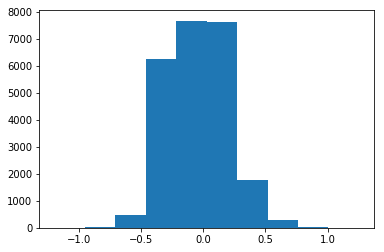

In [3]:
X = []
for sample in samples:
    angle = float(sample[3])
    X.append(angle)
    X.append(angle+0.25)
    X.append(angle-0.25)
plt.hist(X)

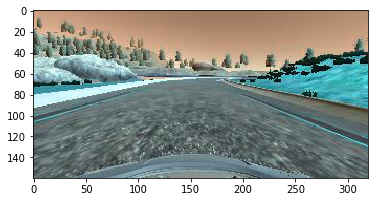

In [54]:
sample   = samples[8000]
filename = "./data/IMG/"+ sample[0].split("/")[-1]
image    = cv2.imread(filename)
plt.imshow(image)

### Generator

Create generator to preprocess data

In [8]:
def process_image(filename, angle):
    pass

# generator
def samples_generator(in_samples, batch_size=32):
    batch_size = int(batch_size/2)
    
    samples = []
    for sample in in_samples:
        center = "./data/IMG/"+ sample[0].split("/")[-1]
        left   = "./data/IMG/"+sample[1].split("/")[-1]
        right  = "./data/IMG/"+sample[2].split("/")[-1]
        angle  = float(sample[3])
        samples.append([left, angle+0.25])
        samples.append([right, angle-0.25])
        samples.append([center, angle])
        
        
    # Get total number of samples
    num_samples = len(samples)

    while True:
        shuffle(samples)
        for offset in range(0,batch_size, num_samples):
            # CSV data center,left,right,steering,throttle,brake,speed
            # Get batch
            batch_samples = samples[offset:offset+batch_size]
            # Process each image in the batch
            images = []
            angles = []
            for batch_sample in batch_samples:
                image = cv2.imread(batch_sample[0])
                #left_image   = cv2.imread("./data/IMG/"+batch_sample[1].split("/")[-1])
                #right_image  = cv2.imread("./data/IMG/"+batch_sample[2].split("/")[-1])

                #center_image = transform.resize(center_image, (66,200))

                #correction   = 0.25
                angle = batch_sample[1]
                #left_angle   = center_angle + correction
                #right_angle  = center_angle - correction
                images.append(image)
                angles.append(angle)

                image_flipped = np.fliplr(image)
                angle_flipped = -angle
                images.append(image_flipped)
                angles.append(angle_flipped)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

#### Create traning anf validation


In [9]:
train_generator = samples_generator(train_samples, batch_size=32)
validation_generator = samples_generator(validation_samples, batch_size=32)

### Build model

In [10]:
opt = Adam(lr=0.0001)

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Convolution2D(24, 5,5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(36, 5,5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(48, 5,5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(64, 3,3, subsample=(1, 1), activation="relu"))
model.add(Convolution2D(64, 3,3, subsample=(1, 1), activation="relu"))
model.add(Flatten())
model.add(Dense(1164,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(100,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mse", optimizer=opt)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 160, 320, 3)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
cropping2d_2 (Cropping2D)        (None, 90, 320, 3)    0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_2[0][0]               
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_6[0][0]            
___________________________________________________________________________________________

### Train

In [11]:
batch_size  = 32
epochs      = 15
samples_per_epoch  = math.ceil((len(train_samples)*3*2)/batch_size) * batch_size
nb_val_samples     = math.ceil((len(validation_samples)*3*2) / batch_size) * batch_size

history = model.fit_generator(
    train_generator, 
    samples_per_epoch=samples_per_epoch, 
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples, 
    nb_epoch=epochs,
    verbose=1).history

Epoch 1/15
38592/38592 [==============================] - 144s - loss: 0.0284 - val_loss: 0.0208
Epoch 2/15
38592/38592 [==============================] - 142s - loss: 0.0214 - val_loss: 0.0166
Epoch 3/15
38592/38592 [==============================] - 142s - loss: 0.0186 - val_loss: 0.0163
Epoch 4/15
38592/38592 [==============================] - 131s - loss: 0.0167 - val_loss: 0.0147
Epoch 5/15
38592/38592 [==============================] - 127s - loss: 0.0144 - val_loss: 0.0142
Epoch 6/15
38592/38592 [==============================] - 128s - loss: 0.0130 - val_loss: 0.0136
Epoch 7/15
38592/38592 [==============================] - 127s - loss: 0.0115 - val_loss: 0.0127
Epoch 8/15
38592/38592 [==============================] - 127s - loss: 0.0106 - val_loss: 0.0138
Epoch 9/15
38592/38592 [==============================] - 127s - loss: 0.0094 - val_loss: 0.0135
Epoch 10/15
38592/38592 [==============================] - 127s - loss: 0.0087 - val_loss: 0.0142
Epoch 11/15
38592/38592 [====

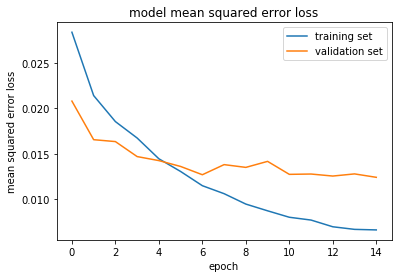

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save("model.h5")


In [13]:
def test_generator(samples, batch_size):
    # Get total number of samples
    num_samples = len(samples)

    while True:
        for offset in range(0,batch_size, num_samples):
            # CSV data center,left,right,steering,throttle,brake,speed
            # Get batch
            batch_samples = samples[offset:offset+batch_size]
            # Process each image in the batch
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread("./data/IMG/"+batch_sample[0].split("/")[-1])
                
                
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

              
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train

            
y = model.predict_generator(test_generator(samples, 32), val_samples=32)    

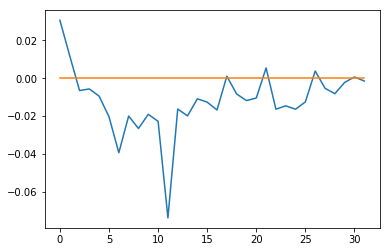

In [16]:
X = []
for sample in samples:
    X.append(float(sample[3]))
x = X[0:32]
plt.plot([i for i in range(0,32)], y)
plt.plot([i for i in range(0,32)], x)


(43, 158)
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.15724394  0.16000116
   0.13858232]
 [ 0.0448077   0.03849334  0.         ...,  0.17864862  0.19062063
   0.20849535]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.07070701  0.06267452
   0.00987388]
 [ 0.          0.          0.         ...,  0.01039923  0.07271463
   0.07684276]]


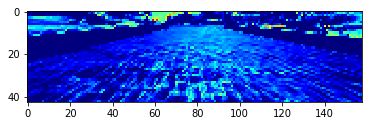

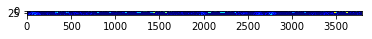

In [97]:
from keras import backend as K



layer = model.layers[2]

sample   = samples[0]
filename = "./data/IMG/"+ sample[0].split("/")[-1]
image    = cv2.imread(filename)
image   = np.array([image])


# funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
func = K.function([model.layers[0].input], [model.layers[2].output])
activation = func([image])
activation_map = activation[0]
#plt.imshow(activation[0][0])
print(activation_map[0][:,:,0].shape)
activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
print(activation_map[0][:,:,0])
plt.imshow(activation_map[0][:,:,0], interpolation='None', cmap='jet')
plt.figure()
plt.imshow(activations, interpolation='None', cmap='jet')